<a href="https://colab.research.google.com/github/weedge/doraemon-nb/blob/main/langchain/rag/langgraph_agentic_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- ⭐️ https://arxiv.org/html/2501.09136

# Agentic RAG（智能体 RAG）

在本教程中，我们将构建一个[检索智能体](https://python.langchain.com/docs/tutorials/qa_chat_history)。当您希望 LLM（大型语言模型）来决定是从向量存储（vectorstore）中检索上下文，还是直接响应用户时，检索智能体会非常有用。

学完本教程后，我们将完成以下工作：

1.  获取并预处理将用于检索的文档。
2.  将这些文档索引（index）以便进行语义搜索，并为智能体创建一个检索器工具（retriever tool）。
3.  构建一个 agentic RAG 系统，使其能够决定何时使用该检索器工具。

![](https://raw.githubusercontent.com/langchain-ai/langgraph/refs/heads/main/docs/docs/tutorials/rag/assets/screenshot_2024_02_14_3_43_58_pm.png)
## 设置

让我们下载所需的包并设置我们的 API 密钥：

In [ ]:
!pip install --quiet -U langgraph langchain_community langchain-openai  langchain-google-genai langchain-text-splitters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.9/469.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 8.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take int

In [ ]:
!pip list | grep -E "langchain|langgraph"

langchain                                0.3.27
langchain-classic                        1.0.0
langchain-community                      0.4.1
langchain-core                           1.0.3
langchain-google-genai                   3.0.1
langchain-openai                         1.0.2
langchain-text-splitters                 1.0.0
langgraph                                1.0.2
langgraph-checkpoint                     3.0.1
langgraph-prebuilt                       1.0.2
langgraph-sdk                            0.2.9


接下来，我们需要为 OpenAI（我们将使用的 LLM）和 Tavily（我们将使用的搜索工具）设置 API 密钥。

In [ ]:
from google.colab import userdata
import os

os.environ["OPENAI_API_KEY"]=userdata.get("ZHIPU_API_KEY")
os.environ["TAVILY_API_KEY"]=userdata.get("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"]=userdata.get("GOOGLE_API_KEY")
os.environ["GITEE_API_KEY"]=userdata.get("GITEE_API_KEY")

In [ ]:
os.environ["LANGSMITH_API_KEY"]=userdata.get("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"

\!\!\! tip
注册 [LangSmith](https://www.google.com/search?q=https.docs.smith.langchain.com) 以快速发现问题并提高您的 LangGraph 项目的性能。LangSmith 允许您使用跟踪数据来调试、测试和监控使用 LangGraph 构建的 LLM 应用程序。

## 1\. 预处理文档

1.  获取要在我们的 RAG 系统中使用的文档。我们将使用 [Lilian Weng 精彩博客](https://www.google.com/search?q=httpshttps://lilianweng.github.io/)中最新的三篇文章。我们将首先使用 `WebBaseLoader` 工具来获取这些页面的内容：

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
os.environ["USER_AGENT"] = "achatbot-demo"

urls = [
    "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/",
    "https://lilianweng.github.io/posts/2024-07-07-hallucination/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/",
]

docs = [WebBaseLoader(url).load() for url in urls]

In [ ]:
len(docs)

3

2. 将获取到的文档拆分成更小的块，以便将其索引到我们的向量存储中：

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

docs_list = [item for sublist in docs for item in sublist]
print(len(docs_list))

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)
print(len(doc_splits))

3
41


In [ ]:
doc_splits[0].page_content.strip()

"Reward Hacking in Reinforcement Learning | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      Reward Hacking in Reinforcement Learning\n    \nDate: November 28, 2024  |  Estimated Reading Time: 37 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nBackground\n\nReward Function in RL\n\nSpurious Correlation\n\n\nLet’s Define Reward Hacking\n\nList of Examples\n\nReward hacking examples in RL tasks\n\nReward hacking examples in LLM tasks\n\nReward hacking examples in real life\n\n\nWhy does Reward Hacking Exist?\n\n\nHacking RL Environment\n\nHacking RLHF of LLMs\n\nHacking the Training Process\n\nHacking the Evaluator\n\nIn-Context Reward Hacking\n\n\nGeneralization of Hacking Skills\n\nPeek into Mitigations\n\nRL Algorithm Improvement\n\nDetecting Reward Hacking\n\nData Analysis of RLHF\

#### Embedding model

In [ ]:
from langchain_openai import OpenAIEmbeddings

### from langchain_cohere import CohereEmbeddings

# Set embeddings
# https://ai.gitee.com/serverless-api#embedding-rerank
# 100 api calls per day, free tier ..................NO!!!! ❄️
embd = OpenAIEmbeddings(
    base_url="https://ai.gitee.com/v1",
    model="Qwen3-Embedding-8B",#4096
    api_key=os.environ["GITEE_API_KEY"],
    dimensions=1024,
    check_embedding_ctx_length=False,
    chunk_size=1000,
)



In [ ]:
vector = embd.embed_query("Today is a sunny day and I will get some ice cream.")
print(vector)

## 2. 创建检索器工具 (Create a retriever tool)

现在我们有了拆分后的文档，我们可以将它们索引到一个向量存储（vector store）中，以便用于语义搜索。

1.  使用内存中的（in-memory）向量存储和 OpenAI 嵌入（OpenAI embeddings）：

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vectorstore = InMemoryVectorStore(embedding=embd)
while len(doc_splits) > 0:
    documents = doc_splits[:10]
    print(f"{len(documents)=}")
    vectorstore.add_documents(documents=documents)
    doc_splits = doc_splits[10:]
retriever = vectorstore.as_retriever()

len(documents)=10
len(documents)=10
len(documents)=10
len(documents)=10
len(documents)=1


2. 使用 LangChain 预构建的 `create_retriever_tool` 来创建检索器工具：

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts.",
)

3. Test the tool:

In [ ]:
retriever_tool.invoke({"query": "types of reward hacking"})

'Or\n@article{weng2024rewardhack,\n  title   = "Reward Hacking in Reinforcement Learning.",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2024",\n  month   = "Nov",\n  url     = "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"\n}\nReferences#\n[1] Andrew Ng & Stuart Russell. “Algorithms for inverse reinforcement learning.”. ICML 2000.\n[2] Amodei et al. “Concrete problems in AI safety: Avoid reward hacking.” arXiv preprint arXiv:1606.06565 (2016).\n[3] Krakovna et al. “Specification gaming: the flip side of AI ingenuity.” 2020.\n[4] Langosco et al. “Goal Misgeneralization in Deep Reinforcement Learning” ICML 2022.\n[5] Everitt et al. “Reinforcement learning with a corrupted reward channel.” IJCAI 2017.\n[6] Geirhos et al. “Shortcut Learning in Deep Neural Networks.” Nature Machine Intelligence 2020.\n[7] Ribeiro et al. “Why Should I Trust You?”: Explaining the Predictions of Any Classifier. KDD 2016.\n[8] Nagarajan et al. “Understanding 

## 3\. 生成查询

现在，我们将开始为我们的 agentic RAG 图构建组件([nodes](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#nodes) and [edges](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#edges))

:::python
请注意，这些组件将在 `MessagesState`  上运行——这是一种图状态（graph state），它包含一个 `messages` 键，键值为一个[聊天消息](https://python.langchain.com/docs/concepts/messages/)列表。
:::

:::js
请注意，这些组件将在 `MessagesZodState` 上运行——这是一种图状态（graph state），它包含一个 `messages` 键，键值为一个[聊天消息](https://js.langchain.com/docs/concepts/messages/)列表。
:::

1.  构建一个 `generate_query_or_respond` 节点。它将调用 LLM（大型语言模型）根据当前的图状态（消息列表）生成响应。根据输入的消息，它将决定是使用检索器工具（retriever tool）进行检索，还是直接响应用户。请注意，我们通过 `.bind_tools` 方法，让我们之前创建的 `retriever_tool` 能够被这个聊天模型访问：

In [ ]:
from langchain_openai import ChatOpenAI

# zhipu
llm=ChatOpenAI(
  base_url="https://open.bigmodel.cn/api/paas/v4",
  model="glm-4.5-flash",
  max_tokens=32768,
  temperature=0
)


In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

# google
llm=ChatGoogleGenerativeAI(
  #model="gemini-2.5-flash",
  model="gemini-2.5-pro",# ok
  temperature=0
)

In [ ]:
from langgraph.graph import MessagesState


def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = llm.bind_tools([retriever_tool]).invoke(state["messages"])
    return {"messages": [response]}

2. 在一个随机输入上尝试它：

In [ ]:
input = {"messages": [{"role": "user", "content": "hello!"}]}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================

[{'type': 'text', 'text': "Hello there! How can I help you today? I can search for information about Lilian Weng's blog posts.", 'extras': {'signature': 'CpYBAdHtim8MQGJ6PUg4CFR2f4mLOombX9z4UrU+abLcuXHMYLheTISABeMiggysGeK9zQoEAqvWdhD6TCfsypFieBMXqI/FwOQim04awwpkPiwZoTL9iocmkmKlOAbo3HfYD6LWyHto3ohM2lpbQCVnmUUPAWZTHJiCIKW6Id5ZXl4pznh3KT3Q7puUgLxQzOVmZutCCszS'}}]


3. 提一个需要语义搜索的问题：

In [ ]:
input = {
    "messages": [
        {
            "role": "user",
            "content": "What does Lilian Weng say about types of reward hacking?",
        }
    ]
}
generate_query_or_respond(input)["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (c06593dc-408d-4add-b1e3-7e8fc114d834)
 Call ID: c06593dc-408d-4add-b1e3-7e8fc114d834
  Args:
    query: types of reward hacking


## 4\. 评估文档 (Grade documents)

1.  添加一个[conditional-edges](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/concepts/low_level.md#conditional-edges) ——`grade_documents`—— 来判断检索到的文档是否与问题相关。我们将使用一个具有结构化输出模式 `GradeDocuments` 的模型来进行文档评估。`grade_documents` 函数将根据评估决策（`generate_answer` 或 `rewrite_question`）返回接下来要跳转到的节点的名称：

In [ ]:
from pydantic import BaseModel, Field
from typing import Literal

GRADE_PROMPT = (
    "You are a grader assessing relevance of a retrieved document to a user question. \n "
    "Here is the retrieved document: \n\n {context} \n\n"
    "Here is the user question: {question} \n"
    "If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n"
    "Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."
)


# highlight-next-line
class GradeDocuments(BaseModel):
    """Grade documents using a binary score for relevance check."""

    binary_score: str = Field(
        description="Relevance score: 'yes' if relevant, or 'no' if not relevant"
    )



def grade_documents(
    state: MessagesState,
) -> Literal["generate_answer", "rewrite_question"]:
    """Determine whether the retrieved documents are relevant to the question."""
    question = state["messages"][0].content
    context = state["messages"][-1].content

    prompt = GRADE_PROMPT.format(question=question, context=context)
    response = (
        llm
        # highlight-next-line
        .with_structured_output(GradeDocuments).invoke(
            [{"role": "user", "content": prompt}]
        )
    )
    score = response.binary_score
    print(score)
    if score == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"

2. 使用工具响应中不相关的文档来运行它：

In [ ]:
from langchain_core.messages import convert_to_messages

input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}
grade_documents(input)

'rewrite_question'

3. 确认相关文档被（正确）分类：

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}
grade_documents(input)

yes


'generate_answer'

## 5. 重写问题 (Rewrite question)

1.  构建 `rewrite_question` 节点。检索器工具（retriever tool）可能会返回不相关的文档，这表明需要改进原始的用户问题。为此，我们将调用 `rewrite_question` 节点：

In [ ]:
REWRITE_PROMPT = (
    "Look at the input and try to reason about the underlying semantic intent / meaning.\n"
    "Here is the initial question:"
    "\n ------- \n"
    "{question}"
    "\n ------- \n"
    "Formulate an improved question:"
)


def rewrite_question(state: MessagesState):
    """Rewrite the original user question."""
    messages = state["messages"]
    question = messages[0].content
    prompt = REWRITE_PROMPT.format(question=question)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [{"role": "user", "content": response.content}]}

2. Try it out:


In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {"role": "tool", "content": "meow", "tool_call_id": "1"},
        ]
    )
}

response = rewrite_question(input)
print(response["messages"][-1]["content"])

**Initial Question:**
What does Lilian Weng say about types of reward hacking?

**Reasoning about Intent:**
The user is asking for specific information from a particular source, Lilian Weng, who is a known authority in the AI/ML space. The query isn't just about "reward hacking" in general, but specifically about a framework or taxonomy she has created. The user likely wants more than just a list of names; they want to understand the categories themselves, what distinguishes them, and how they work. The intent is to retrieve a structured explanation of her specific contribution to this topic.

**Improved Question:**
Summarize Lilian Weng's classification of reward hacking. For each category she proposes, please provide a definition and a key example she uses to illustrate it.


## 6. 生成答案

1.  构建 `generate_answer` 节点：如果我们通过了评估器（grader）的检查，我们就可以根据原始问题和检索到的上下文生成最终答案：

In [ ]:
GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [ ]:
input = {
    "messages": convert_to_messages(
        [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            },
            {
                "role": "assistant",
                "content": "",
                "tool_calls": [
                    {
                        "id": "1",
                        "name": "retrieve_blog_posts",
                        "args": {"query": "types of reward hacking"},
                    }
                ],
            },
            {
                "role": "tool",
                "content": "reward hacking can be categorized into two types: environment or goal misspecification, and reward tampering",
                "tool_call_id": "1",
            },
        ]
    )
}

response = generate_answer(input)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

I don't know. The provided context does not mention Lilian Weng. Therefore, I cannot answer what she says about the types of reward hacking.


## 7. 组装图 (Assemble the graph)

* 从 `generate_query_or_respond` (生成查询或响应) 节点开始，并决定是否需要调用 `retriever_tool` (检索器工具)。
* 使用 `tools_condition` (工具条件) 路由到下一步：
    * 如果 `generate_query_or_respond` 返回了 `tool_calls` (工具调用)，则调用 `retriever_tool` 来检索上下文。
    * 否则，直接响应用户。
* 评估检索到的文档内容与问题的相关性 (`grade_documents` 节点)，并路由到下一步：
    * 如果不相关，则使用 `rewrite_question` (重写问题) 节点来重写问题，然后再次调用 `generate_query_or_respond`。
    * 如果相关，则继续执行 `generate_answer` (生成答案) 节点，并使用包含检索到的文档上下文的 `ToolMessage` 来生成最终响应。

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

workflow = StateGraph(MessagesState)

# Define the nodes we will cycle between
workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(rewrite_question)
workflow.add_node(generate_answer)

workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate_answer", END)
workflow.add_edge("rewrite_question", "generate_query_or_respond")

# Compile
graph = workflow.compile()

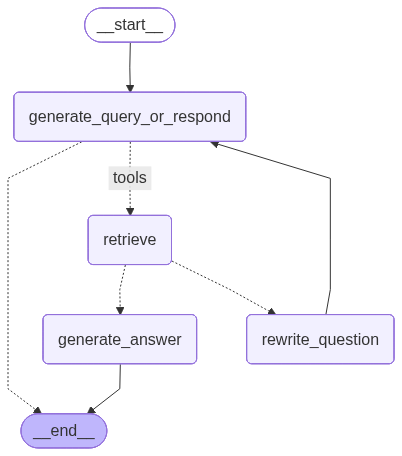

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## 8. Run the agentic RAG


In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What does Lilian Weng say about types of reward hacking?",
            }
        ]
    }
):
    for node, update in chunk.items():
        print("Update from node", node)
        update["messages"][-1].pretty_print()
        print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (ffa6fe06-6200-45a7-a617-a179019c37d0)
 Call ID: ffa6fe06-6200-45a7-a617-a179019c37d0
  Args:
    query: types of reward hacking



yes
Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Or
@article{weng2024rewardhack,
  title   = "Reward Hacking in Reinforcement Learning.",
  author  = "Weng, Lilian",
  journal = "lilianweng.github.io",
  year    = "2024",
  month   = "Nov",
  url     = "https://lilianweng.github.io/posts/2024-11-28-reward-hacking/"
}
References#
[1] Andrew Ng & Stuart Russell. “Algorithms for inverse reinforcement learning.”. ICML 2000.
[2] Amodei et al. “Concrete problems in AI safety: Avoid reward hacking.” arXiv preprint arXiv:1606.06565 (2016).
[3] Krakovna et al. “Specification gaming: the flip side of AI ingenuity.” 2020.
[4

trace: https://smith.langchain.com/public/b7fc14db-71b2-4c27-8ba7-6deab78067fb/r